In [1]:
import seaborn as sns
from sklearn.mixture import BayesianGaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans

import pandas as pd
import numpy as np

from pathlib import Path
import csv

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


In [2]:
def read_files(path, width=20, height=13):
    if not path:
        return None
    if path.is_dir():
        data = []
        for filename in path.glob('*'):
            data.extend(load_file(filename, width, height))
        return data
    else:
        return load_file(path, width, height)


def load_file(filename, width, height):
    reader = csv.reader(open(filename, 'r'), delimiter='\t')
    data = []
    for row in reader:
        data.extend(row)

    if len(data) % (13*20) != 0:
        raise Exception("Ammount of values in file {} doesn't match width {} and height {}".format(filename, width, height))
        
    return pd.to_numeric(data, errors='ignore', downcast='integer').reshape((-1, height, width))

In [3]:
legal = read_files(Path('../touchpad_capture/real_data/legal'))
illegal = read_files(Path('../touchpad_capture/real_data/illegal'))

nontouch = read_files(Path('../touchpad_capture/real_data/nontouches'))
touch = np.concatenate((legal, illegal)) # Doesn't matter if it's a finger (legal) or a palm (illegal), only care if it's touching the touchpad or not


In [32]:
touch_features = pd.DataFrame({
    "min": np.min(touch, axis=(1,2)),
    "max": np.max(touch, axis=(1,2)),
    "mean": np.mean(touch, axis=(1,2)),
    "var": np.var(touch, axis=(1,2)),
    "sum": np.sum(touch, axis=(1,2)),
    "ptp": np.ptp(touch, axis=(1,2)),
    "std": np.std(touch, axis=(1,2)),
    "trace": np.trace(touch, axis1=1, axis2=2),

    "target": 0
})

nontouch_features = pd.DataFrame({
    "min": np.min(nontouch, axis=(1,2)),
    "max": np.max(nontouch, axis=(1,2)),
    "mean": np.mean(nontouch, axis=(1,2)),
    "var": np.var(nontouch, axis=(1,2)),
    "sum": np.sum(nontouch, axis=(1,2)),
    "ptp": np.ptp(nontouch, axis=(1,2)),
    "std": np.std(nontouch, axis=(1,2)),
    "trace": np.trace(nontouch, axis1=1, axis2=2),

    "target": 1
})

features = pd.concat((nontouch_features, touch_features))

SOURCE https://towardsdatascience.com/the-art-of-finding-the-best-features-for-machine-learning-a9074e2ca60d

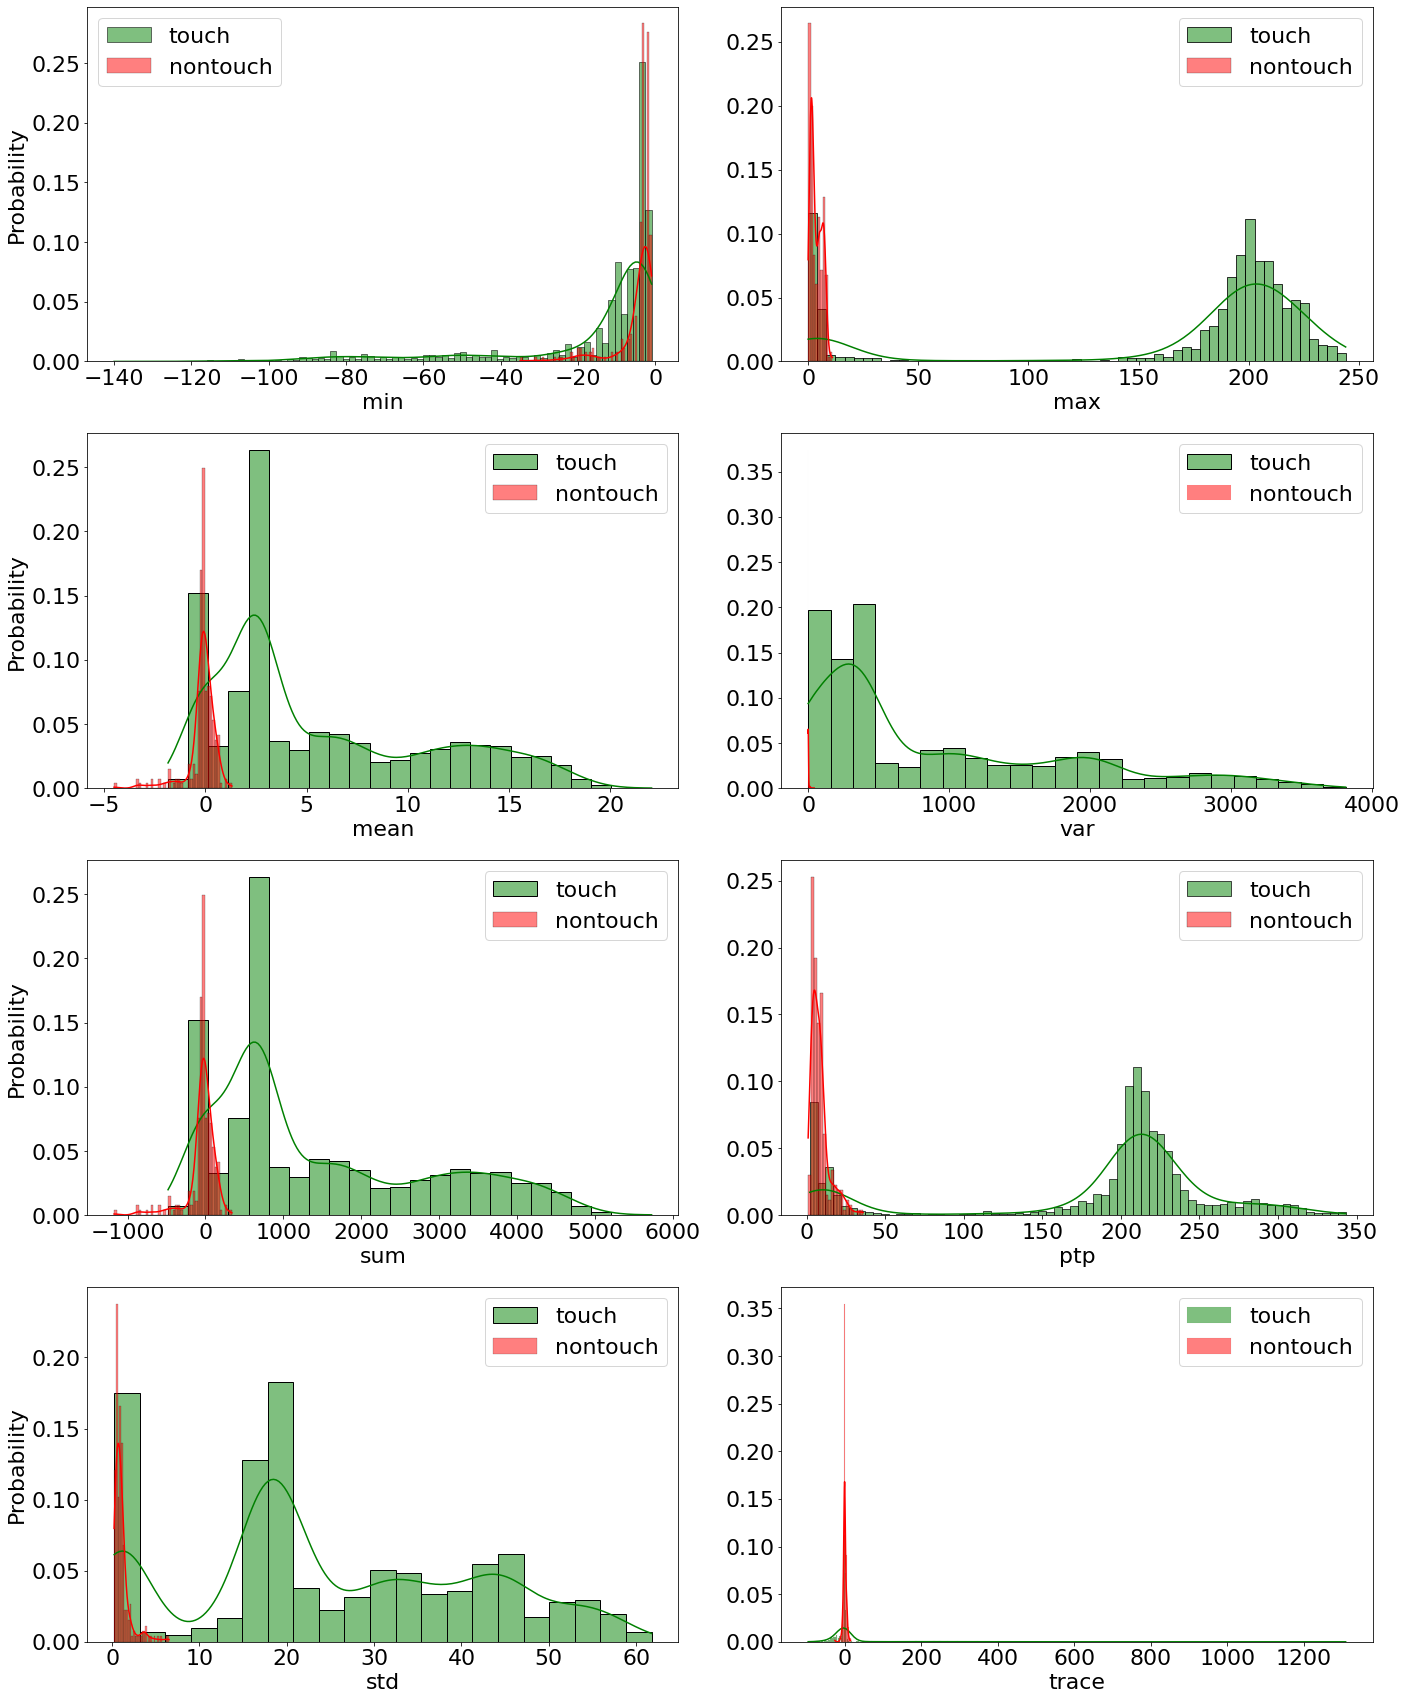

In [49]:
fig = plt.figure(figsize=(20, 25))
plt.rcParams.update({'font.size': 22})
i = 1
for feature in features.columns[: features.columns.slice_locs(end='trace')[1]]: # Cycle through columns until and including "trace"
    plt.subplot(4, 2, i)
    sns.histplot(data=touch_features, x=feature, kde=True, stat="probability", color='g', label='touch')
    sns.histplot(data=nontouch_features, x=feature, kde=True, stat="probability", color='r', label='nontouch')
    if i % 2 == 0:
        plt.ylabel(None)
    plt.legend(loc='best')
    i += 1
# fig.suptitle('Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig('data_elimination_feature_distribution.pdf')

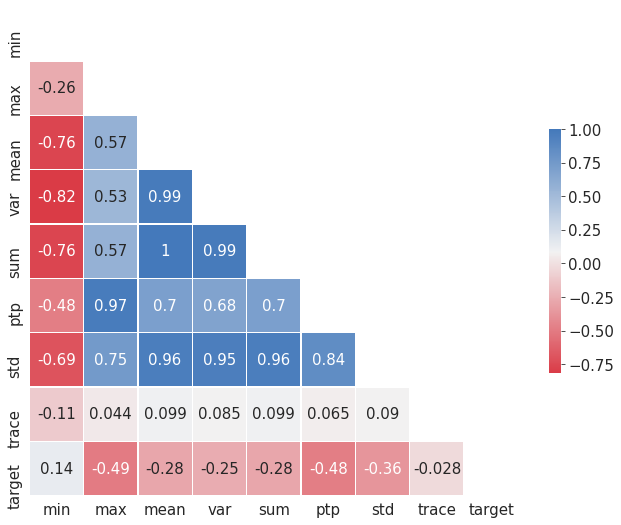

In [22]:
corr = features.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.set_style(style = 'white')
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True,
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.title('Feature Correlation')
plt.savefig('data_elimination_feature_corr.pdf')

In [44]:
shape = (13,20)
tuple(np.flip(shape))


(20, 13)

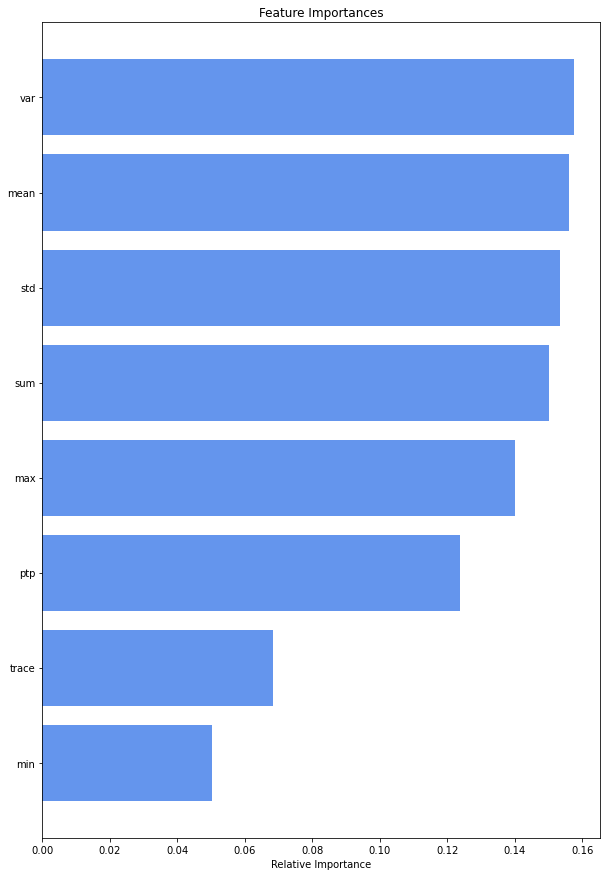

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split# Spliiting data into test and train sets

X_train, X_test, y_train, y_test = train_test_split(features.drop('target', axis=1), features['target'], test_size=0.20, random_state=0)# fitting the model
model = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)# plotting feature importances
features_forest = features.drop('target', axis=1).columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='cornflowerblue', align='center')
plt.yticks(range(len(indices)), [features_forest[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [26]:
def get_merginal_mean(arr,dim="x", meanNN_TF=False):
        '''
        E(x) = int x f(x) dx
        
        arr      : np.array containing 2-d heatmap, shape is (height, width) 
        dim      : if "x", the marginal mean of X (width) is calcualted
                   if "y", the marginal mean of Y (height)is calcualted 
        meanNN_TF: if False, the marginal mean is calculated using all the pixels.
                   if True, then the marginal mean is calculated using the neighboor of the high marginal density region.
                   The "neighboor" is calculated in two steps:
                   (1) order the intensity of the marginal density 
                   in the decreasing manner, 
                   (2) include the top densities until the corresponding pixel coordinate hits the pixel border.
                   
        '''
        if dim == "x":
            axis = 0
        elif dim == "y":
            axis = 1
        mardens = arr.sum(axis=axis)
        asort   = np.argsort(mardens)[::-1]
        
        if meanNN_TF:
            Npixel = np.min(np.where((asort == 0) | (asort == (len(asort)-1) ))) + 1
        else: 
            Npixel = -1 
        mardens = mardens[asort][:Npixel]
        mardens = mardens / np.sum(mardens) ## rescale so that marginal density adds up to 1
        
        xcoor   = asort[:Npixel]
        
        meanx   = np.sum((xcoor*mardens)[:Npixel])
        return(meanx)
    
def get_merginal_sd(arr,dim="x",verbose=False,meanNN_TF=False):
        '''
         E( (x - barx)**2 ) = int (x-barx)**2 f(x) dx
         
        arr     : np.array containing 2-d heatmap, shape is (height, width) 
        dim     : if "x", the marginal mean of X (width) is calcualted
                  if "y", the marginal mean of Y (height)is calcualted 
        meanNN_TF: if False, the marginal mean is calculated using all the pixels.
                   if True, then the marginal mean is calculated using the neighboor of the high marginal density region.
                   The "neighboor" is calculated in two steps:
                   (1) order the intensity of the marginal density 
                   in the decreasing manner, 
                   (2) include the top densities until the corresponding pixel coordinate hits the pixel border.
        '''
        if dim == "x":
            axis = 0
        elif dim == "y":
            axis = 1
        mardens = arr.sum(axis=axis)
        xcoor   = np.arange(len(mardens))
        
        meanx   = get_merginal_mean(arr, dim=dim, meanNN_TF=meanNN_TF)
        assert(False)
        varx    = np.sqrt(np.sum((xcoor - meanx)**2*mardens))
        if verbose:
            print("{} total dens = {:4.3f}, mean = {:5.2f}".format(
                  dim,
                  np.sum(mardens),
                  meanx)
                 )
        return(varx)
def get_cov(arr,verbose=True,meanNN_TF=False):
        '''
         E( (x - barx)*(y - bary) ) = int (x-barx)*(y - bary) f(x,y) dxdy
          
        arr     : np.array containing 2-d heatmap, shape is (height, width) 
        meanNN_TF: if False, the marginal mean is calculated using all the pixels.
                   if True, then the marginal mean is calculated using the neighboor of the high marginal density region.
                   The "neighboor" is calculated in two steps:
                   (1) order the intensity of the marginal density 
                   in the decreasing manner, 
                   (2) include the top densities until the corresponding pixel coordinate hits the pixel border.
                   
                    recommended to set True to improve the variance estimate performance when not all the density is included in the heatmap image.
                    
        '''
        
        ## prepare the storage space
        x_coor_mat = np.zeros_like(arr)
        for icol in range(x_coor_mat.shape[1]):
            x_coor_mat[:, icol] = icol
            
        y_coor_mat = np.zeros_like(arr)
        for irow in range(y_coor_mat.shape[0]):
            y_coor_mat[irow, :] = irow
            
        meanx   = get_merginal_mean(arr, dim = "x", meanNN_TF=meanNN_TF) ## scalar
        meany   = get_merginal_mean(arr, dim = "y", meanNN_TF=meanNN_TF) ## scalar 
      
        cov     = np.sum((x_coor_mat - meanx)*(y_coor_mat - meany )*arr)

        return(cov)

<AxesSubplot:>

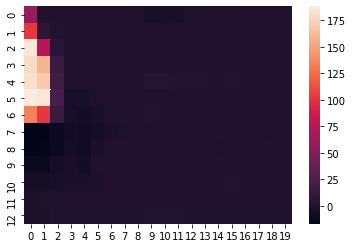

In [6]:
illegal[0].shape
image = illegal[0]
sns.heatmap(image)

In [27]:
get_merginal_sd(image, dim='x')

AssertionError: 

In [28]:
%debug

> <ipython-input-26-f69662c64b83>(36)get_merginal_sd()
     34 
     35 def get_merginal_sd(arr,dim="x",verbose=False,meanNN_TF=False):
---> 36         assert(False)
     37         '''
     38          E( (x - barx)**2 ) = int (x-barx)**2 f(x) dx



In [30]:
image = np.array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,  75., 140.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0., 105., 220.,  69.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  52.,  42.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  63., 216., 156.,   0.,   0.,   0., 194., 181.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  56., 207., 116.,   0.,   0.,   0.,  95.,  65.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])
image.shape


(13, 20)

In [37]:
shape_diff = (4, 1)
indice1 = -shape_diff[0]
indice2= -shape_diff[1]

print(indice1, indice2)
image[:image.shape[0], :image.shape[1]].shape

-4 -1


(13, 20)

In [29]:
print(type(image))

<class 'list'>


In [26]:
type(-shape_diff[0]), type(-shape_diff[1])

(int, int)